In [2]:
import matplotlib.pyplot as plt
from pathlib import Path
import nevergrad as ng
from tqdm import tqdm
import pandas as pd
import numpy as np
import pickle
import optuna
import plotly

In [3]:
def load_array_data(base_dirs: dict[str, Path]):
    """
    Load all EDM data as arrays.

    Returns:
        data: dict
            data[edm_state][run_id] = {
                "X": X,  # lambda_frac grid
                "Y": Y,  # theta grid (mrad)
                "Z": Z,  # probability density
            }
    """
    data = {}
    for edm_state, dir_path in base_dirs.items():
        state_data = {}
        for file in sorted(dir_path.glob("G2_*.pkl")):
            run_id = int(file.stem.split("_")[1])
            with open(file, "rb") as f:
                X, Y, Z = pickle.load(f)
            state_data[run_id] = {
                "X": X,
                "Y": Y * 1000,
                "Z": Z,
            }
        data[edm_state] = state_data
    return data


In [5]:
def plot_heatmap(X, Y, Z, w=None, title="", xlabel="", ylabel="",
                 cbar_label="", save_path=None):
    """
    Generic 2D heatmap plotter with optional weighting.
    Normalises using p = Z * dθ * dλ so that Σ(p_i * w_i_norm) = Σ(w_i).
    """
    # Compute bin widths
    dtheta = np.abs(Y[1, 0] - Y[0, 0])
    dlambda = np.abs(X[0, 1] - X[0, 0])
    p = Z * dtheta * dlambda  # actual probability per bin

    if w is not None:
        # Compute normalisation constant
        numerator = np.sum(p)
        denominator = np.sum(p * w)
        N = numerator / denominator if denominator > 0 else 1.0
    Z_plot = Z * (N*w if w is not None else 1.0)

    plt.figure(figsize=(6, 5))
    plt.pcolormesh(X, Y, Z_plot, shading='auto', cmap='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar(label=cbar_label)
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=150)
        plt.close()
    else:
        plt.show()



def save_probability_maps(data_all, output_base=Path("outputs"), save=True, plotting=False):
    if not save:
        print("Skipping save — files already generated.")
        return

    for edm_state, runs in tqdm(data_all.items(), desc="EDM States"):
        folder_name = f"{edm_state} EDM"
        output_dir = output_base / folder_name
        output_dir.mkdir(parents=True, exist_ok=True)

        for run_id, grids in runs.items():
            X, Y, Z = grids["X"], grids["Y"], grids["Z"]
            fname = f"G2_{run_id:02}_{edm_state.lower()}EDM.png"
            save_path = output_dir / fname

            plot_heatmap(
                X, Y, Z,
                title=f"{folder_name} — Run {run_id:02}",
                xlabel=r"Fractional energy ($\lambda$)",
                ylabel=r"Longitudinal angle ($\theta_L$) [mrad]",
                cbar_label="Probability density",
                save_path=save_path
            )


In [6]:

base_dirs = {
    "Without": Path("data/Without EDM"),
    "With": Path("data/With EDM"),
}

data_all = load_array_data(base_dirs)

save_probability_maps({"With": data_all["With"]}, output_base=Path("outputs"),save=False)

Skipping save — files already generated.


In [7]:
# --- Core metric calculator ---
def calculate_metrics_array(Z, Y, N, w=None):
    """
    Calculate weighted or unweighted mean, sigma, and SEM for one (theta, lambda) slice.

    Parameters
    ----------
    Z : np.ndarray
        Probability densities for this slice (1D vs theta)
    Y : np.ndarray
        Corresponding theta values [mrad]
    N : float
        Event count scaling factor
    w : np.ndarray or None
        Optional weights (same shape as Z)

    Returns
    -------
    mean, sig, sem
    """
    probs = N * Z * 1e-3

    if w is None:
        # Unweighted
        n = np.sum(probs)
        if n == 0:
            return np.nan, np.nan, np.nan
        mean = np.sum(probs * Y) / n
        var = np.sum(probs * (Y - mean)**2) / n
        sig = np.sqrt(max(var, 0.0))
        sem = sig / np.sqrt(n)
        return mean, sig, sem

    else:
        # Weighted
        w = np.abs(w)
        n = np.sum(probs * w)
        if n == 0:
            return np.nan, np.nan, np.nan

        neff = (np.sum(probs * w)**2) / np.sum(probs * w**2)
        neff = max(neff, 1.0)

        mean = np.sum(w * probs * Y) / n
        var = np.sum(probs * w * (Y - mean)**2) / n
        sig = np.sqrt(max(var, 0.0))
        sem = sig / np.sqrt(neff)
        return mean, sig, sem



# --- FOM calculator ---
def compute_fom_over_lambdas(data_all, n_vals, lambda_values, weight_func=None, plotting=False, normalize_weights=True):
    """
    Compute FOM(λ) for multiple event counts (N) and optional weighting function.

    Parameters
    ----------
    data_all : dict
        Simulation data from load_array_data()
    n_vals : list[float]
        Event count scaling factors
    lambda_values : list[float]
        Lambda (energy fraction) values to evaluate
    weight_func : callable or None
        Function weight_func(Y, X) returning 2D weights
    plotting : bool
        Show per-lambda plots
    normalize_weights : bool
        Whether to normalise weights to max=1
    """
    metrics = {}
    states = ["With", "Without"]

    # Assume all runs share grid structure
    X = data_all["With"][0]["X"][0, :]
    Y = data_all["With"][0]["Y"][:, 0]

    for N in n_vals:
        all_metrics = []
        for lambda_curr in lambda_values:
            i_lambda = np.argmin(np.abs(X - lambda_curr))

            run_means, run_sems = {s: [] for s in states}, {s: [] for s in states}
            for edm_state in states:
                for run_id, grids in data_all[edm_state].items():
                    Z = grids["Z"][:, i_lambda]
                    Y_vals = grids["Y"][:, 0]

                    # Apply weighting if provided
                    if weight_func is not None:
                        w_grid = weight_func(grids["Y"], grids["X"])
                        w = w_grid[:, i_lambda]
                        if normalize_weights:
                            w = np.abs(w)
                            w /= np.max(w)
                    else:
                        w = None

                    mean, sig, sem = calculate_metrics_array(Z, Y_vals, N, w=w)
                    run_means[edm_state].append(mean)
                    run_sems[edm_state].append(sem)

            # Compute FOM for this λ
            means_with = np.array(run_means["With"])
            sems_with = np.array(run_sems["With"])
            FOM = np.sum(means_with**2 / (2 * sems_with**2))
            all_metrics.append({"lambda_frac": lambda_curr, "FOM": FOM})

        metrics[N] = all_metrics
    return metrics



# --- FOM plotting helper ---
def plot_fom(metrics, n_vals):
    """Plot FOM(λ) curves."""
    plt.figure(figsize=(6, 6))
    for N in n_vals:
        lambdas = [m["lambda_frac"] for m in metrics[N]]
        foms = [m["FOM"] for m in metrics[N]]
        plt.plot(lambdas, foms, label=f"N = {N}")
    plt.xlabel(r"$\lambda$")
    plt.ylabel(r"FOM($\lambda$)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


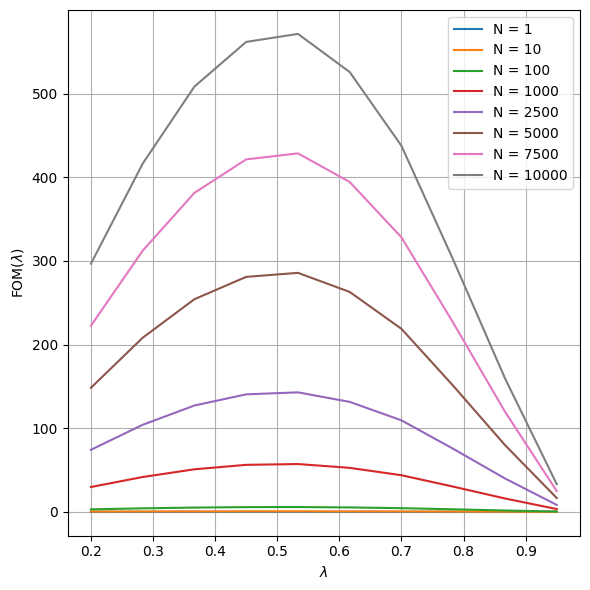

Max FOM = 0.057 at λ = 0.533 for N = 1


In [8]:
n_vals = [1,10,100,1000,2500,5000,7500,10000]
lambda_values = np.linspace(0.2, 0.95, 10)
metrics = compute_fom_over_lambdas(data_all, n_vals, lambda_values)
plot_fom(metrics, n_vals)

N_target = 1  # or whichever N you want
fom_data = metrics[N_target]

# Convert to arrays
lambdas = [entry["lambda_frac"] for entry in fom_data]
foms     = [entry["FOM"] for entry in fom_data]

# Find the max
idx_max = np.argmax(foms)
lambda_max = lambdas[idx_max]
fom_max = foms[idx_max]

print(f"Max FOM = {fom_max:.3f} at λ = {lambda_max:.3f} for N = {N_target}")

In [9]:
edm_state = "With"
run_id = 7
grids = data_all[edm_state][run_id]
TH, LAM, Z = grids["Y"], grids["X"], grids["Z"]

weight_functions = [
    ("Uniform 1s", lambda Y, X: np.ones_like(Y)),
    ("Uniform 5s", lambda Y, X: 5 * np.ones_like(Y)),
    ("Central energy", lambda Y, X: np.exp(-((X / 10)**2))),
    ("Edge energy", lambda Y, X: 1 - np.exp(-((X / 10)**2))),
    ("Central theta", lambda Y, X: np.exp(-((Y / 10)**2))),
    ("Edge theta", lambda Y, X: 1 - np.exp(-((Y / 100)**2))),
    ("Small angle, large energy", lambda Y, X: np.exp(-((Y / 100)**2)) * X),
    ("Large angle, small energy", lambda Y, X: (1 - np.exp(-((Y / 100)**2))) * X),
]

plotting = True
if plotting:
    for name, func in weight_functions:
        w = func(TH, LAM)
        plot_heatmap(
            LAM, TH, Z, w=w,
            title=name,
            xlabel=r"$\lambda$ (energy fraction)",
            ylabel=r"$\theta$ (mrad)",
            cbar_label="Weighted prob. density",
            save_path=f"outputs/Weighting/{name}.png"
        )
else:
    print("Plotting disabled.")


In [10]:
# Parameters
lambda_values = np.linspace(0.2,0.95,10)
n_vals = [1]

# Storage for results
metrics = {}

# Loop through each analytic weight
for name, weight_func in weight_functions:
    print(f"Evaluating weighting: {name}")
    # Compute FOM for this weighting
    metrics[name] = compute_fom_over_lambdas(
        data_all=data_all,
        n_vals=n_vals,
        lambda_values=lambda_values,
        weight_func=weight_func,
        plotting=plotting
    )

Evaluating weighting: Uniform 1s
Evaluating weighting: Uniform 5s
Evaluating weighting: Central energy
Evaluating weighting: Edge energy
Evaluating weighting: Central theta
Evaluating weighting: Edge theta
Evaluating weighting: Small angle, large energy
Evaluating weighting: Large angle, small energy


Uniform 1s, 0.0608
Uniform 5s, 0.0608
Central energy, 0.0608
Edge energy, 0.0608
Central theta, 0.0434
Edge theta, 0.137
Small angle, large energy, 0.0605
Large angle, small energy, 0.137


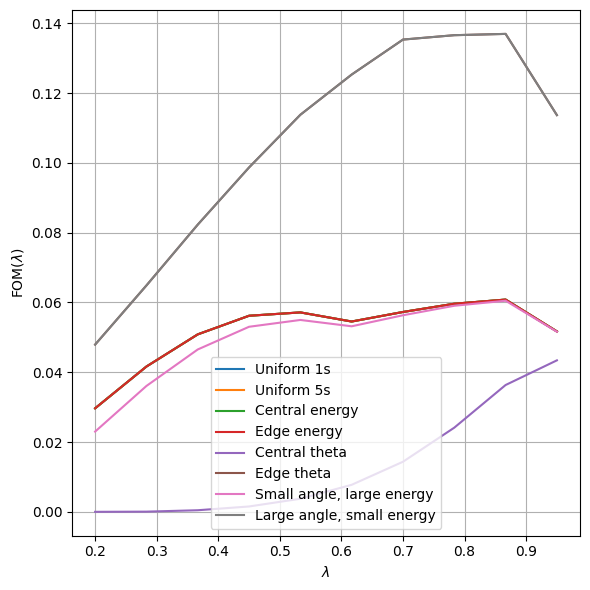

In [11]:
fig = plt.figure(figsize=(6, 6))

for name, _ in weight_functions:
    data = metrics[name][n_vals[0]]
    lambdas = [entry["lambda_frac"] for entry in data]
    foms = [entry["FOM"] for entry in data]
    print(f"{name}, {max(foms):.3g}")
    plt.plot(lambdas, foms, label=name)

plt.xlabel(r"$\lambda$")
plt.ylabel(r"FOM($\lambda$)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def compute_fom_over_grid(data_all, n_vals, weight_func, plotting=False):
    metrics = {}
    dtheta, dlambda = None, None

    for N in n_vals:
        FOM_total = 0.0

        for run_id, grids in data_all["With"].items():
            Y, X, Z = grids["Y"], grids["X"], grids["Z"]
            w_grid = weight_func(Y, X, run_id=run_id)

            if dtheta is None:
                dtheta = np.abs(Y[1, 0] - Y[0, 0])
                dlambda = np.abs(X[0, 1] - X[0, 0])

            slice_lam = 

            p = Z * dtheta * dlambda
            numerator = np.sum(p)
            denominator = np.sum(p * w_grid)
            Nnorm = numerator / denominator if denominator > 0 else 1.0
            w_norm = Nnorm * w_grid
            p_w = p * w_norm

            total_pw = np.sum(p_w)
            if total_pw <= 0 or np.isnan(total_pw):
                continue

            theta_vals = Y[:, 0]
            mean = np.sum(p_w * theta_vals[:, None]) / total_pw
            var = np.sum(p_w * (theta_vals[:, None] - mean) ** 2) / total_pw
            sig = np.sqrt(max(var, 0.0))
            N_eff = N * total_pw
            sem = sig / np.sqrt(N_eff)
            FOM_total += mean**2 / (2 * sem**2)

        metrics[N] = [{"lambda_frac": "2D", "FOM": FOM_total}]
    return metrics

In [13]:
# --- Parameters ---
plotting = False
output_dir = Path("outputs/Difference")
output_dir.mkdir(parents=True, exist_ok=True)

# --- Loop over all runs ---
for run_id in range(29):
    # Extract "With" and "Without" data for this run
    grids_with = data_all["With"][run_id]
    grids_without = data_all["Without"][run_id]

    Y, X = grids_with["Y"], grids_with["X"]
    Z_with = grids_with["Z"]
    Z_without = grids_without["Z"]

    # --- Compute difference (With - Without) ---
    Z_diff = Z_with - Z_without

    # --- Plotting ---
    if plotting:
        plt.figure(figsize=(6, 5))
        plt.pcolormesh(X, Y, Z_diff, shading="auto", cmap="coolwarm")
        plt.xlabel(r"$\lambda$ (energy fraction)")
        plt.ylabel(r"$\theta$ [mrad]")
        plt.title(fr"$\Delta$ Probability Density (With - Without EDM) for Run = {run_id:02}")
        plt.colorbar(label="Difference")
        plt.tight_layout()
        plt.savefig(output_dir / f"Difference_{run_id:02}.png", dpi=150)
        plt.show()

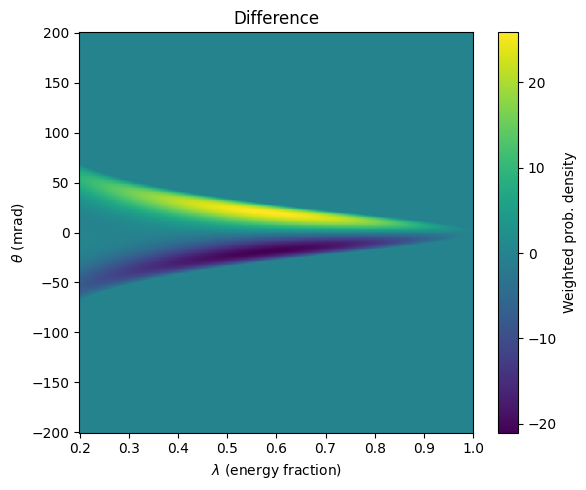

In [14]:
# --- Parameters ---
run_id = 7
plotting = True
output_dir = Path("outputs/Weighting")
output_dir.mkdir(parents=True, exist_ok=True)

# --- Extract base grid and difference ---
grids_with = data_all["With"][run_id]
grids_without = data_all["Without"][run_id]

Y, X = grids_with["Y"], grids_with["X"]
Z_with = grids_with["Z"]
Z_without = grids_without["Z"]

# --- Compute difference map (With - Without) ---
Z_diff = Z_with - Z_without

# --- Use the difference as a weight map ---
w = Z_diff.copy()
name = "Difference"

# --- Apply weighting to base probability density (e.g., "With" EDM) ---
Z_weighted = Z_with * w

# --- Plot result ---
plt.figure(figsize=(6, 5))
plt.pcolormesh(X, Y, Z_weighted, shading="auto", cmap="viridis")
plt.title(name)
plt.xlabel(r"$\lambda$ (energy fraction)")
plt.ylabel(r"$\theta$ (mrad)")
plt.colorbar(label="Weighted prob. density")
plt.tight_layout()
plt.savefig(output_dir / f"{name}.png", dpi=150)
plt.show()

In [15]:
# --- Uniform weight  ---
uniform_weight = lambda Y, X, run_id=None: np.ones_like(Y)
metrics_unweighted = compute_fom_over_grid(
    data_all, [1, 10, 100, 1000, 10000], uniform_weight
)

# --- Difference weight  ---
def diff_weight_per_run(Y, X, run_id):
    """Compute run-specific difference weight |Z_with - Z_without|."""
    Z_with = data_all["With"][run_id]["Z"]
    Z_without = data_all["Without"][run_id]["Z"]
    return np.abs(Z_with - Z_without)

def diff_weight_func(Y, X, run_id=None):
    if run_id is None:
        return np.ones_like(Y)
    return diff_weight_per_run(Y, X, run_id)

metrics_diff = compute_fom_over_grid(
    data_all, [1, 10, 100, 1000, 10000], diff_weight_func
)

# --- Compare results ---
for N in [1, 10, 100, 1000, 10000]:
    print(
        f"N={N:<6}  Unweighted={metrics_unweighted[N][0]['FOM']:.4f}   "
        f"Diff-weighted={metrics_diff[N][0]['FOM']:.4f}"
    )

N=1       Unweighted=17.8418   Diff-weighted=37.4670
N=10      Unweighted=178.4177   Diff-weighted=374.6701
N=100     Unweighted=1784.1770   Diff-weighted=3746.7015
N=1000    Unweighted=17841.7700   Diff-weighted=37467.0148
N=10000   Unweighted=178417.6999   Diff-weighted=374670.1477


In [16]:
def plot_weight(Y, X, W, name="Weight", save_path=None):
    """
    Plot 1D (vs theta) and 2D contour of a weight array.

    Parameters
    ----------
    Y, X : 2D arrays
        Theta (Y) and lambda (X) coordinate grids.
    W : 2D array
        Weight array to visualise.
    name : str
        Label or title for the weight.
    save_path : str or Path
        Optional — if provided, saves instead of showing inline.
    """

    # 1D slice through the central lambda index
    mid_idx = W.shape[1] // 2
    theta_vals = Y[:, 0]
    weight_slice = W[:, mid_idx]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # --- 1D plot ---
    print(mid_idx)
    axes[0].plot(theta_vals, weight_slice, color="blue", lw=1.5)
    axes[0].set_xlabel(r"$\theta_L$ [rads]")
    axes[0].set_ylabel("Weight")

    # --- 2D contour plot ---
    c = axes[1].pcolormesh(X, Y, W, shading="auto", cmap="Blues")
    axes[1].set_xlabel(r"Fractional Lab Frame Energy ($\lambda$)")
    axes[1].set_ylabel(r"Longitudinal Angle ($\theta_L$) [rads]")
    fig.colorbar(c, ax=axes[1], label="Weighting (w)")

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=200)
        plt.close()
    else:
        plt.show()

In [17]:
# Example 1: uniform weight
run_id = 7
Y, X, Z = data_all["With"][run_id]["Y"], data_all["With"][run_id]["X"], data_all["With"][run_id]["Z"]
W_uniform = np.ones_like(Z)
plot_weight(Y, X, W_uniform, name="Uniform",save_path="outputs/Weighting/uniform 2d plot.png")

# Example 2: difference weight
Z_with = data_all["With"][run_id]["Z"]
Z_without = data_all["Without"][run_id]["Z"]
W_diff = np.abs(Z_with - Z_without)
plot_weight(Y, X, W_diff, name="Difference Weight",save_path="outputs/Weighting/difference 2d plot.png")


250
250


In [18]:
def parametric_weight(Y,X,a_theta,a_lambda,b_lambda):
    """
    Simple parametric weighting function
    """
    return np.exp(-a_theta * Y**2) * np.exp(-a_lambda * (X - b_lambda)**2)

250


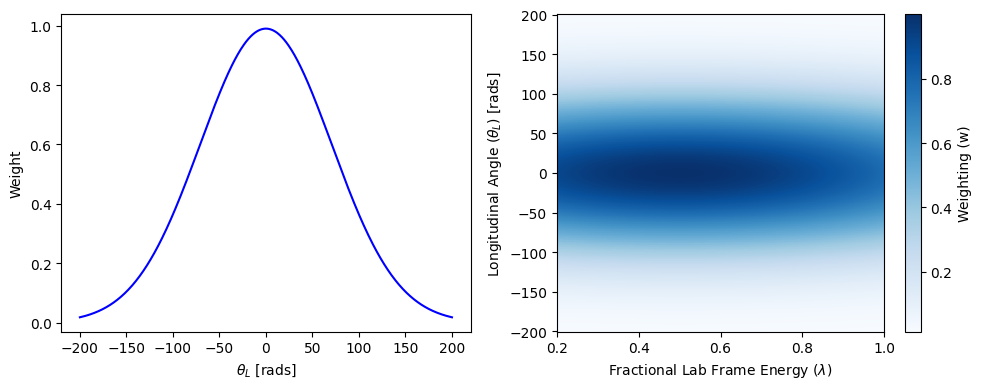

250


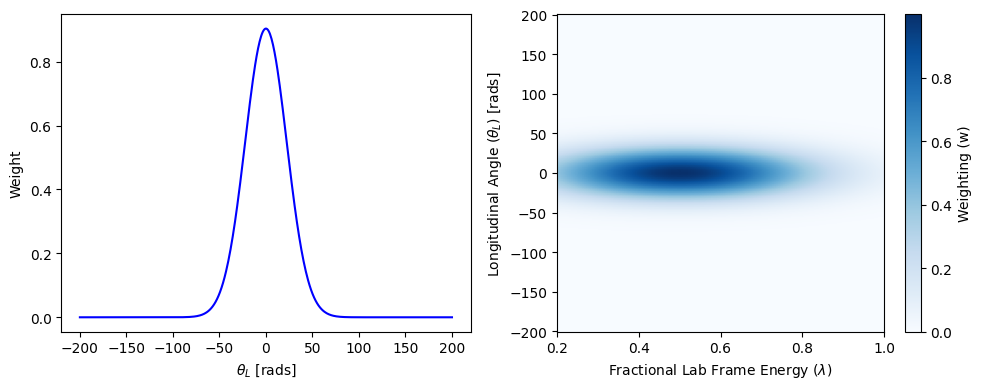

250


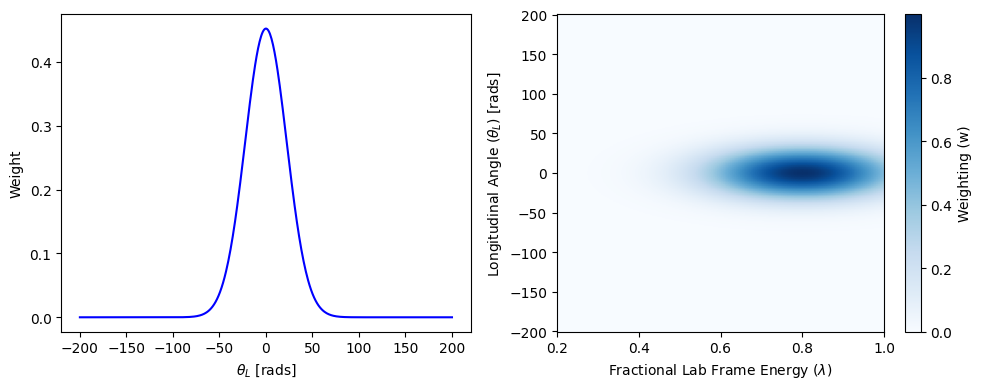

250


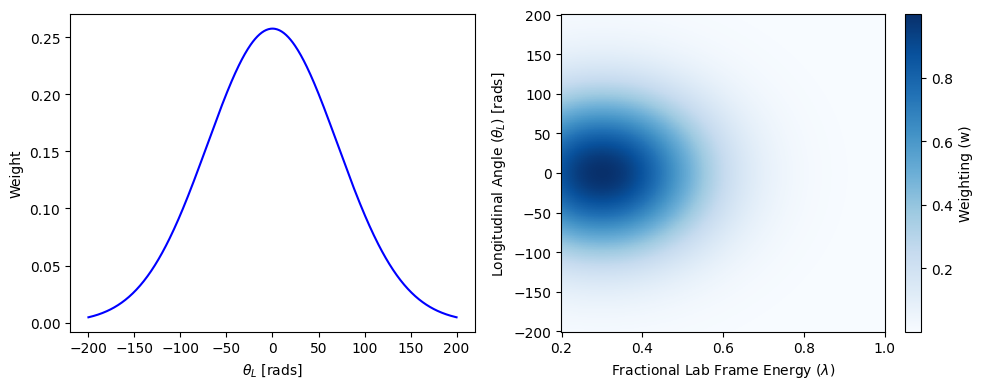

In [19]:
run_id = 7
Y, X, Z = data_all["With"][run_id]["Y"], data_all["With"][run_id]["X"], data_all["With"][run_id]["Z"]

# Example Gaussian weight parameter sets
example_params = [
    {"a_theta": 1e-4, "a_lambda": 1, "b_lambda": 0.5},   # Broad, almost uniform
    {"a_theta": 1e-3, "a_lambda": 10, "b_lambda": 0.5},  # Central Gaussian bump
    {"a_theta": 1e-3, "a_lambda": 20, "b_lambda": 0.8},  # High-energy focused
    {"a_theta": 1e-4, "a_lambda": 15, "b_lambda": 0.3},  # Low-energy focused
]

for params in example_params:
    W = parametric_weight(Y, X, **params)
    plot_weight(Y, X, W, name=f"aθ={params['a_theta']}, aλ={params['a_lambda']}, bλ={params['b_lambda']}")

In [20]:
def evaluate_fom(a_theta, a_lambda, b_lambda, N=10000):
    """
    Evaluate the Figure of Merit (FOM) for a given set of Gaussian weight parameters.

    Parameters
    ----------
    a_theta : float
        Angular spread parameter controlling width in theta (Y).
    a_lambda : float
        Energy spread parameter controlling width in lambda (X).
    b_lambda : float
        Central energy location of the weighting.
    N : int, optional
        Number of simulated particles/events to use (default = 10000).

    Returns
    -------
    float
        Computed Figure of Merit (FOM) for the specified weight parameters.
    """

    # Define weight function using the parameters
    def weight_func(Y, X, run_id=None):
        return np.exp(-a_theta * Y**2) * np.exp(-a_lambda * (X - b_lambda)**2)

    # Compute the FOM for this weighting (only using "With" EDM data)
    metrics = compute_fom_over_grid(data_all, [N], weight_func)

    # Extract and return scalar FOM
    fom_value = metrics[N][0]["FOM"]
    return fom_value

example_params = [
    {"a_theta": 1e-4, "a_lambda": 1, "b_lambda": 0.5},
    {"a_theta": 1e-3, "a_lambda": 10, "b_lambda": 0.5},
    {"a_theta": 1e-3, "a_lambda": 20, "b_lambda": 0.8},
    {"a_theta": 1e-4, "a_lambda": 15, "b_lambda": 0.3},
]

for p in example_params:
    fom = evaluate_fom(**p)
    print(f"aθ={p['a_theta']:.1e}, aλ={p['a_lambda']:.1f}, bλ={p['b_lambda']:.2f} → FOM={fom:.4f}")


aθ=1.0e-04, aλ=1.0, bλ=0.50 → FOM=169777.5863
aθ=1.0e-03, aλ=10.0, bλ=0.50 → FOM=124892.4403
aθ=1.0e-03, aλ=20.0, bλ=0.80 → FOM=249799.3687
aθ=1.0e-04, aλ=15.0, bλ=0.30 → FOM=156030.1333


In [21]:
def objective(trial):
    """
    Objective function for Optuna — maximise the Figure of Merit (FOM)
    by tuning the Gaussian weight parameters.
    """
    # --- Define parameter search ranges ---
    a_theta  = trial.suggest_float("a_theta", 1e-5, 1e-2, log=True)
    a_lambda = trial.suggest_float("a_lambda", 0.5, 50.0, log=True)
    b_lambda = trial.suggest_float("b_lambda", 0.2, 0.9)

    # --- Evaluate FOM for these parameters ---
    fom = evaluate_fom(a_theta, a_lambda, b_lambda, N=10000)

    # Optuna minimises by default; we want to maximise, so return negative
    return -fom


# --- Create and run the study ---
study = optuna.create_study(direction="minimize", study_name="FOM optimisation")
study.optimize(objective, n_trials=200, show_progress_bar=True)

# --- Print best results ---
best_params = study.best_params
best_fom = -study.best_value

print("\nBest parameters found:")
for k, v in best_params.items():
    print(f"  {k} = {v:.6g}")
print(f"Maximum FOM = {best_fom:.4f}")


[I 2025-11-07 16:05:54,949] A new study created in memory with name: FOM optimisation


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-11-07 16:05:55,810] Trial 0 finished with value: -53963.600756632266 and parameters: {'a_theta': 0.0013889923431733926, 'a_lambda': 11.24415907167827, 'b_lambda': 0.2136372117453241}. Best is trial 0 with value: -53963.600756632266.
[I 2025-11-07 16:05:56,440] Trial 1 finished with value: -141879.19523932145 and parameters: {'a_theta': 0.0004705840394216706, 'a_lambda': 0.726979613665144, 'b_lambda': 0.6644167164057939}. Best is trial 1 with value: -141879.19523932145.
[I 2025-11-07 16:05:57,099] Trial 2 finished with value: -175567.09296611339 and parameters: {'a_theta': 1.9153279077276094e-05, 'a_lambda': 0.7449634902280994, 'b_lambda': 0.25018734152947947}. Best is trial 2 with value: -175567.09296611339.
[I 2025-11-07 16:05:57,720] Trial 3 finished with value: -210133.92885508423 and parameters: {'a_theta': 0.0001498844868846457, 'a_lambda': 12.512745971656987, 'b_lambda': 0.6063677679860654}. Best is trial 3 with value: -210133.92885508423.
[I 2025-11-07 16:05:58,394] Tria

In [22]:
optuna.visualization.plot_optimization_history(study)

In [23]:
# --- Extract the best parameters from Optuna ---
best_params = study.best_params
a_theta_best  = best_params["a_theta"]
a_lambda_best = best_params["a_lambda"]
b_lambda_best = best_params["b_lambda"]

print("Best parameters:")
print(f"  a_theta  = {a_theta_best:.3e}")
print(f"  a_lambda = {a_lambda_best:.3f}")
print(f"  b_lambda = {b_lambda_best:.3f}")

# --- Build the corresponding weight map ---
run_id = 7  # or whichever run you want to visualise
Y, X, Z = data_all["With"][run_id]["Y"], data_all["With"][run_id]["X"], data_all["With"][run_id]["Z"]

W_opt = np.exp(-a_theta_best * Y**2) * np.exp(-a_lambda_best * (X - b_lambda_best)**2)

# --- Plot the 1D and 2D visualisations ---
plot_weight(
    Y, X, W_opt,
    name=f"Optimised Weight (aθ={a_theta_best:.1e}, aλ={a_lambda_best:.1f}, bλ={b_lambda_best:.2f})",
    save_path="outputs/Weighting/Optimised_Weight.png"
)


Best parameters:
  a_theta  = 1.041e-05
  a_lambda = 49.993
  b_lambda = 0.864
250


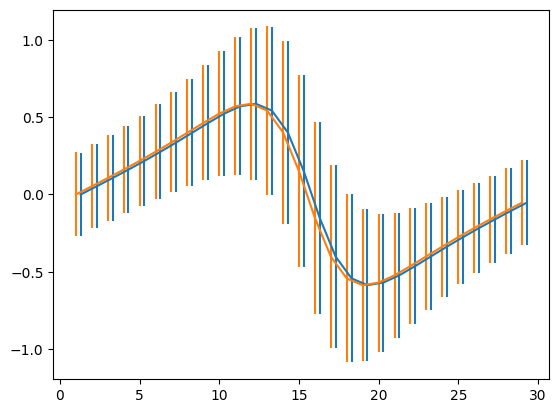

In [56]:
y = np.zeros(29)
y_uw = np.zeros(29)
yerr = np.zeros(29)
yerr_uw = np.zeros(29)

w1 = np.ones_like(W_opt)

l = 0.89
for i in range(29):
    grids = data_all[edm_state][i]
    lamb = grids['X'][0]
    lindex = np.argmin(np.abs(l-lamb))
    z = grids['Z'][:,lindex].transpose()
    #print(lamb, lindex)
    y[i], _, yerr[i] = calculate_metrics_array(grids['Z'][:,lindex],grids['Y'][:,lindex],1000,w=W_opt[:,lindex])
    y_uw[i], _, yerr_uw[i] = calculate_metrics_array(grids['Z'][:,lindex],grids['Y'][:,lindex],1000,w=w1[:,lindex])

plt.errorbar(np.arange(1.3,30.3, 1.0),y,yerr=yerr)
plt.errorbar(np.arange(1,30),y_uw,yerr=yerr_uw)
plt.show()